In [1]:
import gizeh as gz
import json
import numpy as np
import pandas as pd
import glob
from more_itertools.recipes import grouper, pairwise
from PIL import Image
from sklearn.preprocessing import StandardScaler

print("Jupyter online")

Jupyter online


In [2]:
def open_json(jsonfile):
    jsonopen = open(jsonfile)
    jfile = json.load(jsonopen)
    jsonopen.close()
    x = pd.DataFrame(jfile)
    return x

def framenames(path, fps):
    frames = np.arange(0, 900*fps+1, 24).tolist()
    startname = 'frame'
    endname = '_keypoints.json'
    frames = frames[1:]
    framelist = []
    for i in frames:
        framelist.append(path+startname+str(i)+endname)
    return(framelist)

def data_loader(framelist):
    pose1= []
    pose2= []
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    for jsonfile in framelist:
        data = open_json(jsonfile)
        if len(data.index) == 2:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count1 += 1
        if len(data.index) == 3:
            s1 = data.iloc[0,:]
            s2 = data.iloc[2,:]
            count2 += 1
        if len(data.index) == 1:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count3 += 1
        if len(data.index) == 4:        #NEEDS WORK, KN5 frame 216 has 4 skeletons in it
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count4 += 1
        if len(data.index) == 5:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count5 += 1

        sig1 = s1["people"]
        sig2 = s2["people"]

        signer1poses = pd.DataFrame.from_dict(sig1, orient='index')
        signer2poses = pd.DataFrame.from_dict(sig2, orient='index')

        signer1 = signer1poses.iloc[1:5,:]
        signer2 = signer2poses.iloc[1:5,:]

        signer1 = signer1.drop(["face_keypoints_2d"])
        signer2 = signer2.drop(["face_keypoints_2d"])
        
        pose1.append(signer1)
        pose2.append(signer2)
    poses = pose1 + pose2
    print('There are '+str(count3)+' frames with 1 person in them')
    print('There are '+str(count1)+' frames with 2 persons in them')
    print('There are '+str(count2)+' frames with 3 persons in them')
    print('There are '+str(count4)+' frames with 4 persons in them')
    print('There are '+str(count5)+' frames with 5 persons in them')
    return poses

def scale(lst):                                 #Look into standardscaler from sklearn
    newdata = []
    for i,d in enumerate(lst):
        if d.any() > 0:
           newdata.append(d/500)
        else:
            newdata.append(d)
    return newdata

#def scale(lst):
#    scaler = StandardScaler()
#    newdata = scaler.fit_transform(lst)
#    return newdata

def normalizer(lst,nmbr):
    fin = []
    norm = (nmbr*1.8)
    #assuming person 2 always sits on the right in the frame which gives him/her different y coordinates but similar x coordinates.
    z = np.array([norm,0])
    #normalize the y coordinate appropriately for person 1 so relative distances stay the same. 
    for i,d in enumerate(lst):
        if d.any() > 0:
            d = d-z
            fin.append(d)
        else:
            fin.append(d) 
    return fin

def pose_processor(poses):                                                      #Finish pose processor
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervals = np.arange(-1, 75, 3).tolist()
    confidenceintervals = confidenceintervals[1:]
    #print(confidenceintervals)

    #Create x and y coordinates index
    coordinates = np.arange(0, 75, 1).tolist()
    cs1 = set(confidenceintervals)
    coorindex = [x for x in coordinates if x not in cs1]
    #print(coorindex)

    person1 = []
    for framepose in p1:
        signer1 = pd.DataFrame(framepose) 
        skel1 = signer1.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci1 = [skel1[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor1 = [skel1[i] for i in coorindex]
        sk1 = np.array_split(skelcoor1, 25)
        #Normalize on neck Y coordinate as neck position
        neck2 = sk1[1]
        newdata1 = scale(normalizer(sk1, neck2[0]))
        person1.append(newdata1)
        
    person2 = []
    for framepose in p2:
        signer2 = pd.DataFrame(framepose) 
        skel2 = signer2.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci2 = [skel2[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor2 = [skel2[i] for i in coorindex]
        sk2 = np.array_split(skelcoor2, 25)

        newdata2 = scale(sk2)
        person2.append(newdata2)
    #return sk1, sk2
    signers = person1 + person2
    return signers

def hand_processor(poses):                                          #Under  construction
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervalh = np.arange(-1, 63, 3).tolist()
    confidenceintervalh = confidenceintervalh[1:]
    #print(confidenceintervalh)

    #Create x and y coordinates index
    coordinateh = np.arange(0, 63, 1).tolist()
    csi2 = set(confidenceintervalh)
    coorindexhand = [x for x in coordinateh if x not in csi2]
    #print(coorindexhand)

    person1 = []                                        #CHANGE VARIABLE NAME
    for framepose in p1:
        signer1 = pd.DataFrame(framepose) 
        hand1_L = signer1.iloc[1,:]
        hand1_R = signer1.iloc[2,:]
        hand1_L = hand1_L.dropna(axis='rows')
        hand1_R = hand1_R.dropna(axis='rows')
        #Get confidence intervals for signer 1 and 2 per keypoint per hand
        H1L = [hand1_L[i] for i in confidenceintervalh]
        H1R = [hand1_R[i] for i in confidenceintervalh]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        hand1R = [hand1_L[i] for i in coorindexhand]
        hand1L = [hand1_R[i] for i in coorindexhand]
        #print(len(hand1L))
        #Split the list into x, y coordinate arrays
        handR11 = np.array_split(hand1R, 21)
        handL11 = np.array_split(hand1L, 21)
        #Normalize on 240, from Songha Ban's code.
        handR1 = scale(normalizer(handR11, 240))
        handL1 = scale(normalizer(handL11, 240))
        #Join them into 1 list with numpy arrays
        hand1 = [handR1, handL1]
        person1.append(hand1)

    person2 = []                                        #CHANGE VARIABLE NAME
    for framepose in p2:
        signer2 = pd.DataFrame(framepose) 
        hand2_L = signer2.iloc[1,:]
        hand2_R = signer2.iloc[2,:]
        hand2_L = hand2_L.dropna(axis='rows')
        hand2_R = hand2_R.dropna(axis='rows')
        #Get confidence intervals for signer 1 and 2 per keypoint per hand
        H2L = [hand2_R[i] for i in confidenceintervalh]
        H2R = [hand2_R[i] for i in confidenceintervalh]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        hand2R = [hand2_L[i] for i in coorindexhand]
        hand2L = [hand2_R[i] for i in coorindexhand]
        #print(len(hand1L))
        #Split the list into x, y coordinate arrays
        handR22 = np.array_split(hand2R, 21)
        handL22 = np.array_split(hand2L, 21)
        handR2 = scale(handR22)
        handL2 = scale(handL22)
        #Join them into 1 list with numpy arrays
        hand2 = [handR2, handL2]
        person2.append(hand2)
    return person1, person2

def data_shaper(signers, hands):
    poses = signers
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]
    tot = []
    for i in range(0,900):
        newdata1 = []
        for value in p1[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata1.append(x)

        newdata2 = []
        for value in p2[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata2.append(x)
        shaped = np.array(newdata1 + newdata2)
        tot.append(shaped)
    end = np.array(tot)
    end = end.reshape(1,900,100)
    return end

def label_loader(labelspath):
    data = pd.read_csv(labelspath)
    data2 = data.iloc[:,3]
    labels = data2
    labels = np.array(labels)
    return labels

def finish_processing(path,fps,labelspath):
    framelist = framenames(path, fps)
    poses = data_loader(framelist)
    processedsk = pose_processor(poses)
    #processedhands = hand_processor(poses)
    features = processedsk
    #features = data_shaper(processedsk,processedhands)
    labels = label_loader(labelspath)
    return np.array(features)


In [3]:
path = 'D:\Videos thesis\KN5Jan7_poses\KN5Jan7_poses\\'
fps = 24
labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
labels = label_loader(labelspath)
z = finish_processing(path, fps, labelspath)
print(z.shape)
print(labels.shape)

There are 0 frames with 1 person in them
There are 809 frames with 2 persons in them
There are 90 frames with 3 persons in them
There are 1 frames with 4 persons in them
There are 0 frames with 5 persons in them
(1800, 25, 2)
(900,)


In [5]:
np.random.seed(0)
import tensorflow as tf
import torch

from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
poses = z
lengthp = len(poses)
middle = lengthp/2
p1 = poses[:int(middle)]
p2 = poses[int(middle):]

#explain what this does
tf.compat.v1.disable_eager_execution()

tot1 = []
tot2 = []
for i in range(0,900):
        newdata1 = []
        for value in p1[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata1.append(x)
        newdata2 = []
        for value in p2[i]:
            for coordinate in value:
                x = round(coordinate, 8)
                newdata2.append(x)
        tot1.append(newdata1)
        tot2.append(newdata2)
        #for value in labels[i]:
        #        print(value)
final1 = np.array(tot1)
final2 = np.array(tot2)

dataset = np.hstack((final1, final2))
labels = pd.DataFrame(labels)
dataset = pd.DataFrame(dataset)
#df = pd.DataFrame(dataset)
#labels = pd.DataFrame(y)
#mx = df.to_numpy().min()
#print(mx)

X = pd.DataFrame(dataset)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1) # 0.26666 x 0.75 = 0.2

X_train = np.array(X_train)
#X_train = X_train.reshape(1,len(X_train),100)
print(X_train.shape)
X_test = np.array(X_test)
#X_test = X_test.reshape(1,len(X_test),100)
print(X_test.shape)

X_val = np.array(X_val)
print(X_val.shape)


y_train = np.array(y_train)
y_train = np.squeeze(y_train)
#y_train = y_train.reshape(1,len(y_train))
print(y_train.shape)
y_test = np.array(y_test)
y_test = np.squeeze(y_test)
#y_test = y_test.reshape(1,len(y_test))
print(y_test.shape)

y_val = np.array(y_val)
y_val = np.squeeze(y_val)
print(y_val.shape)

(404, 100)
(297, 100)
(199, 100)
(404,)
(297,)
(199,)


Accuracy: 0.5218855218855218
Confusion matrix:
[[ 12  16   1   1]
 [  0 115  11   1]
 [  0  48  22   9]
 [  0  41  14   6]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        30
           1       0.52      0.91      0.66       127
           2       0.46      0.28      0.35        79
           3       0.35      0.10      0.15        61

    accuracy                           0.52       297
   macro avg       0.58      0.42      0.43       297
weighted avg       0.52      0.52      0.46       297

Test accuracy:
0.5218855218855218


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


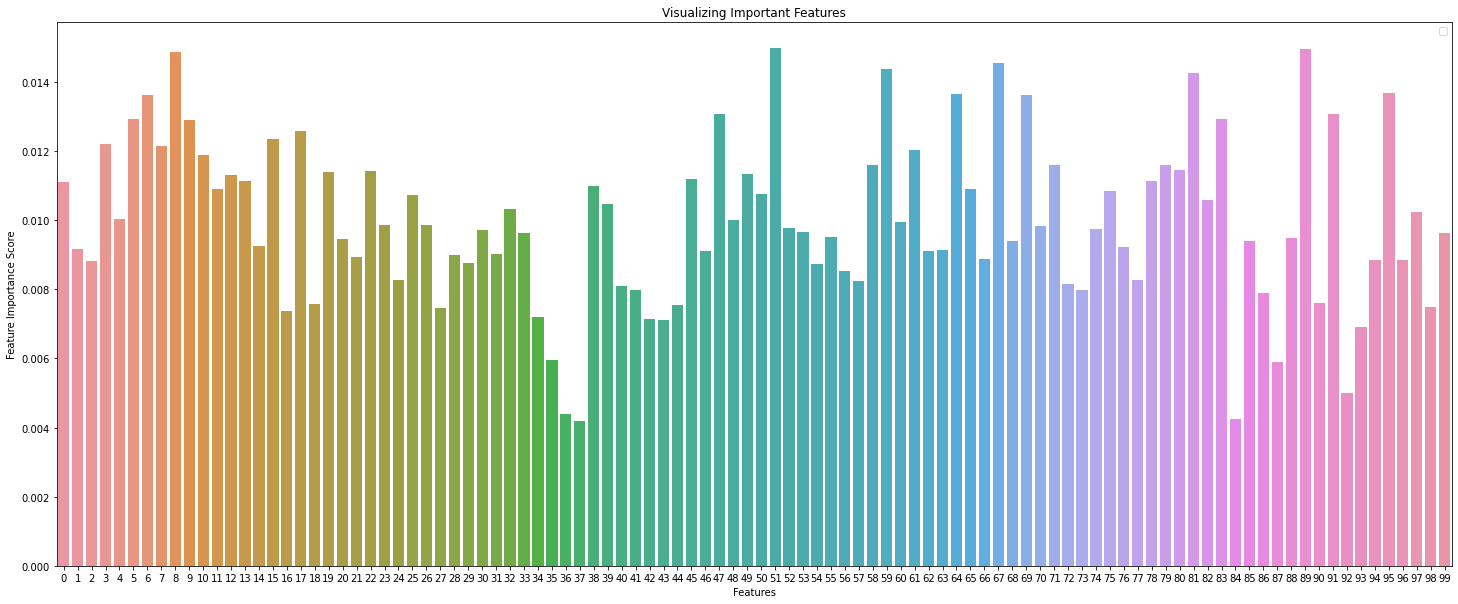

In [36]:
#https://www.datacamp.com/tutorial/random-forests-classifier-python

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

clf=RandomForestClassifier(n_estimators=1000)
history = clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
#print("this is the feature importance (column number):",feature_imp)

test_cm = confusion_matrix(y_test,y_pred)
test_report = classification_report(y_test,y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Confusion matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)
print("Test accuracy:")
print(test_accuracy)

# Creating a bar plot
plt.figure(figsize=(25,10))

sns.barplot(x=feature_imp.index, y=feature_imp)
# Add labels to your graph
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


In [ ]:
#https://spyjetson.blogspot.com/2019/10/jetsonnano-human-pose-estimation-using.html

#SKELETON KEYPOINTS
{
//     {0,  "Nose"},
//     {1,  "Neck"},
//     {2,  "RShoulder"},
//     {3,  "RElbow"},
//     {4,  "RWrist"},
//     {5,  "LShoulder"},
//     {6,  "LElbow"},
//     {7,  "LWrist"},
//     {8,  "MidHip"},
//     {9,  "RHip"},
//     {10, "RKnee"},
//     {11, "RAnkle"},
//     {12, "LHip"},
//     {13, "LKnee"},
//     {14, "LAnkle"},
//     {15, "REye"},
//     {16, "LEye"},
//     {17, "REar"},
//     {18, "LEar"},
//     {19, "LBigToe"},
//     {20, "LSmallToe"},
//     {21, "LHeel"},
//     {22, "RBigToe"},
//     {23, "RSmallToe"},
//     {24, "RHeel"},
// };

#HAND KEYPOINTS
#as seen on left hand when it is held open 
{
//     {0,  "BotR palm"},
//     {1,  "BotL palm"},
//     {2,  "Thumb Bot"},
//     {3,  "Thumb Mid"},
//     {4,  "Thumb Top"},
//     {5,  "Index Bot"},
//     {6,  "Index Mid1"},
//     {7,  "Index Mid2"},
//     {8,  "Index Top"},
//     {9,  "Middle Bot"},
//     {10, "Middle Mid1"},
//     {11, "Middle Mid2"},
//     {12, "Middle Top"},
//     {13, "Ring Bot"},
//     {14, "Ring Mid1"},
//     {15, "Ring Mid2"},
//     {16, "Ring Top"},
//     {17, "Pinky Bot"},
//     {18, "Pinky Mid1"},
//     {19, "Pinky Mid2"},
//     {20, "Pinky Top"},
// };


